# Main playground for exploration of NN SI model

**Author: Zheng Liu**

## Introduction

We are interested in how neural network can help to predict real spatial interaction data.
This notebook aims to provide step-by-step experiments to compare parametric statistic models (OLS/GLM) and non-parametric statistic models (Neural Networks).

In the first part, we prepare data from simulationin order to validate and examine model and real world SI data which will be used at the end in different models especially NN SI models to evaluate performances.

Next part will compare results using OLS/GLM/NN with the dataset you pick. Before getting NN results, implementation of my simple neural network is explicitly given.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf # high-level stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import shap

%matplotlib inline
shap.initjs()

## Data preparation

Following datasets can be loaded by calling functions below:


1. Multiplicative simulation: to simulate SI model data with known parameters
2. Integer Multiplicative simulationL to simulate more real SI model data with known parameters
3. Real world Austria migration: A toy dataset with 72 entries used in Taylor (2016) and Fischer (2001)
3. Real world NYC taxi snippet: Larger dataset with tract-level interactions (1000 entries)

### 1. Multiplicative simulation

In [3]:
#make non-linear dataset
def loadDatasetNonlnMp(row=1000,error=10):
    b0 = 1

    Oi = np.random.rand(row,1)
    Dj = np.random.randint(row,1)
    dij = np.random.rand(row,1)+1.0001
    X = np.hstack((Oi,Dj,dij))
    Xe = error*np.random.rand(row,1)
    Y = b0*Oi*Dj/dij + Xe
    return (X,Y)

In [4]:
#make non-linear dataset
def loadDatasetLogMp(row=1000,error=10):
    b0 = 1
    b1 = 1
    b2 = 1
    b3 = -1
    Oi = np.random.rand(row,1)
    Dj = np.random.randint(row,1)
    dij = np.random.rand(row,1)+1.0001
    X = np.hstack((Oi,Dj,dij))

    Xe = error*np.random.rand(row,1)
    Y = np.exp(b0+ b1*np.log(Oi) + b2*np.log(Dj) + b3*np.log(dij) + Xe)
    return (X,Y)

### 2. Integer Multiplicative simulation

In [5]:
#make non-linear dataset
def loadDatasetNonlnMpInt(row=1000,error=10):
    b0 = 1

    Oi = np.random.randint(1,100,size=(row,1))
    Dj = np.random.randint(1,100,size=(row,1))
    dij = 100 * np.random.rand(row,1)+100.0001
    X = np.hstack((Oi,Dj,dij))
    Xe = error*np.random.rand(row,1)
    Y = np.rint(b0*Oi*Dj/dij + Xe)
    return (X,Y)

In [6]:
#make non-linear dataset
def loadDatasetLogMpInt(row=1000,error=10):
    b0 = 1
    b1 = 1
    b2 = 1
    b3 = -1
    Oi = np.random.randint(1,100,size=(row,1))
    Dj = np.random.randint(1,100,size=(row,1))
    dij = 100 * np.random.rand(row,1)+100.0001
    X = np.hstack((Oi,Dj,dij))

    Xe = error*np.random.rand(row,1)
    Y = np.rint(np.exp(b0+ b1*np.log(Oi) + b2*np.log(Dj) + b3*np.log(dij) + Xe))
    return (X,Y)

### 3. Real world Austria migration

In [7]:
def loadDatasetAustria():
    X = np.load('data/austria_in.npy')
    Y = np.load('data/austria_out.npy')
    return (X,Y)

### 4. Real world NYC taxi snippet

In [8]:
def loadDatasetTaxiSnippet():
    X = np.load('data/simple_taxi_X.npy')
    Y = np.load('data/simple_taxi_Y.npy')
    return (X,Y)

**Take a look at the data distribution**

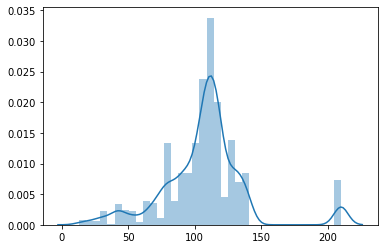

In [9]:
X,Y = loadDatasetTaxiSnippet()
#Oi
sns.distplot(X[:,0])

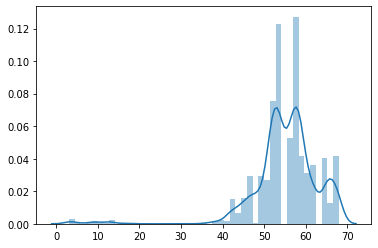

In [10]:
#Di
sns.distplot(X[:,1])

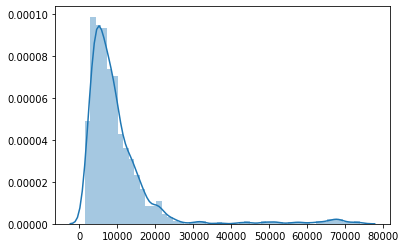

In [11]:
#dij
sns.distplot(X[:,2])

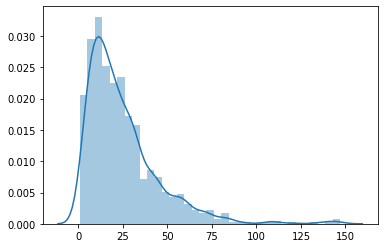

In [12]:
#flow
sns.distplot(Y[:,0])

**Distance and flow are more like Poisson distribution**

In [13]:
def loadDatasetTaxiSnippetScale():
    X = np.load('data/simple_taxi_X.npy')
    Y = np.load('data/simple_taxi_Y.npy')
    X[:,2] = X[:,2]/100
    X = X / 100
    Y = Y / 100
    return (X,Y)

### Load dataset of your choice

In [35]:
dataopt = '4.2'

if(dataopt == '1.1'):
    X,Y = loadDatasetNonlnMp()
elif(dataopt == '1.2'):
    X,Y = loadDatasetLogMp()
elif(dataopt == '2.1'):
    X,Y = loadDatasetNonlnMpInt()
elif(dataopt == '2.2'):
    X,Y = loadDatasetLogMpInt()
elif(dataopt == '3'):
    X,Y = loadDatasetAustria()
elif(dataopt == '4.1'):
    X,Y = loadDatasetTaxiSnippet()
elif(dataopt == '4.2'):
    X,Y = loadDatasetTaxiSnippetScale()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train[:10,:]

array([[0.28],
       [0.37],
       [0.22],
       [0.15],
       [0.77],
       [0.26],
       [1.47],
       [0.47],
       [0.27],
       [0.29]])

## Compare results
Following functions of OLSregression/GLMregression/NNregression will give a **scatterplot, MSE, pearson's R**, of known test data y values vs predicted y values using known X values

### Ordinary Least Square
using package **statsmodels**

In [15]:
def OLSregression(X_train,y_train,X_test,y_test):
    X_train_log = sm.add_constant(np.log(X_train))
    X_test_log = sm.add_constant(np.log(X_test))
    y_train_log = np.log(y_train)
    model = sm.OLS(y_train_log,X_train_log)
    results = model.fit()
    print(results.summary())
    y_pred = np.exp(results.predict(X_test_log))
    pear = scipy.stats.pearsonr(y_test[:,0], y_pred)
    print('Pearson\'s r is {:6f}'.format(pear[0]))
    mse = np.mean((y_test[:,0] - y_pred)**2)
    print('MSE is {:6f}'.format(mse))

    df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test[:,0], 'y_pred':y_pred})
    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="y_test", y="y_pred", data=df)
    X_plot = np.linspace(0,np.max(y_test),400)
    plt.plot(X_plot,X_plot,'r--')    
    return results
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     179.4
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           7.85e-89
Time:                        13:57:22   Log-Likelihood:                -783.93
No. Observations:                 800   AIC:                             1576.
Df Residuals:                     796   BIC:                             1595.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4867      0.058    -25.821      0.0

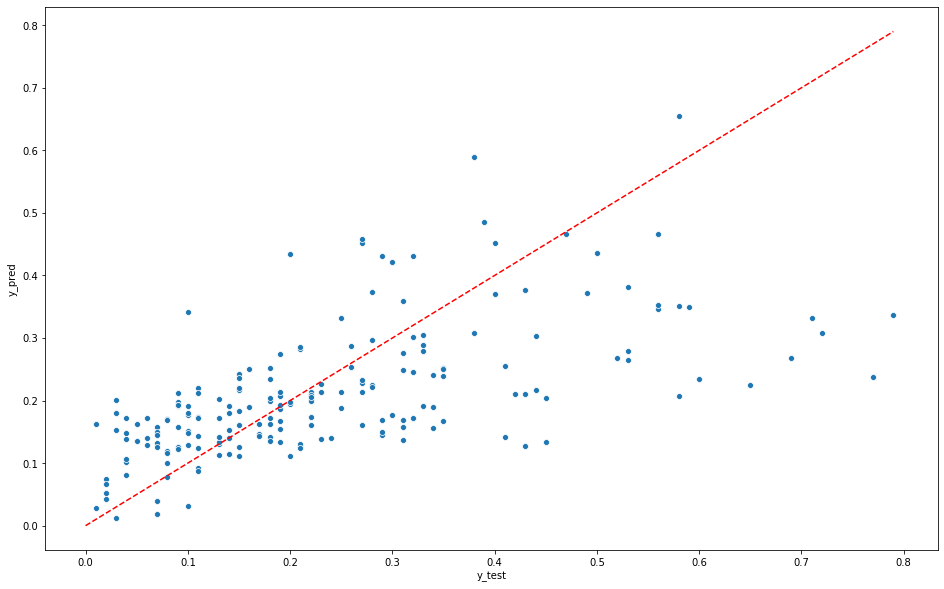

In [16]:
olsresults = OLSregression(X_train,y_train,X_test,y_test)

### Generalized Linear Models
using package **statsmodels**, current support family of *Poisson*.

In [36]:
def GLMregression(X_train,y_train,X_test,y_test,family='Poisson'):
    if family == 'Poisson':
        X_train = sm.add_constant(np.log(X_train))
        X_test = sm.add_constant(np.log(X_test))
        model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
        results = model.fit()
        print(results.summary())

        y_pred = results.predict(X_test,transform=False)
        pear = scipy.stats.pearsonr(y_test[:,0], y_pred)
        print('Pearson\'s r is {:6f}'.format(pear[0]))
        
        mse = np.mean((y_test[:,0] - y_pred)**2)
        print('MSE is {:6f}'.format(mse))
        
        
        df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test[:,0], 'y_pred':y_pred})

        df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
        plt.figure(figsize=(16, 10))
        sns.scatterplot(x="y_test", y="y_pred", data=df)
        X_plot = np.linspace(0,np.max(y_test),400)
        plt.plot(X_plot,X_plot,'r--')    
        return results
    elif family == 'Gaussian':
        X_train = sm.add_constant(np.log(X_train))
        X_test = sm.add_constant(np.log(X_test))
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
        results = model.fit()
        print(results.summary())

        y_pred = results.predict(X_test,transform=False)
        pear = scipy.stats.pearsonr(y_test[:,0], y_pred)
        print('Pearson\'s r is {:6f}'.format(pear[0]))
        
        mse = np.mean((y_test[:,0] - y_pred)**2)
        print('MSE is {:6f}'.format(mse))
        
        
        df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test[:,0], 'y_pred':y_pred})

        df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
        plt.figure(figsize=(16, 10))
        sns.scatterplot(x="y_test", y="y_pred", data=df)
        X_plot = np.linspace(0,np.max(y_test),400)
        plt.plot(X_plot,X_plot,'r--')    
        return results
    else:
        return -1

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  800
Model:                            GLM   Df Residuals:                      796
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -394.34
Date:                Sun, 15 Dec 2019   Deviance:                       67.164
Time:                        14:03:44   Pearson chi2:                     78.8
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0395      0.289     -3.593      0.0

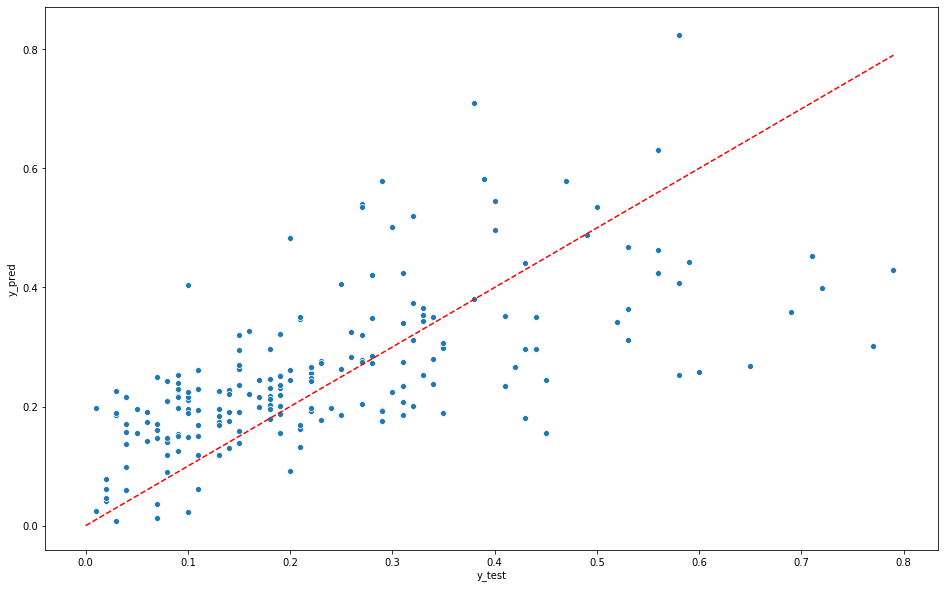

In [37]:
glmresults = GLMregression(X_train,y_train,X_test,y_test,family='Poisson')

### simple Neural Network models
Multi-layer preceptron (MLP) with one hidden layer. Below shows available activation functions including **sigmoid, tanh, ReLU, affine**. 

In [14]:
#activation functions and their gradient functions
def sigmoid(X):
    return 1/(1+np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * (1 - sigmoid(X))

def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
     return 1 - np.tanh(z) ** 2

def ReLU(z):
    return np.clip(z, 0, np.inf)

def ReLU_grad(z):
    return (z > 0).astype(int)

def affine(X,slope=1,intercept=0):
     return slope * X + intercept
    
def affine_grad(X,slope=1,intercept=0):
    return slope * np.ones_like(X)

#### Define neural network model

Construct neural network by using numpy only so that user is able to monitor the changing of weights during training. 

In [15]:

class NeuralNetwork:
    def __init__(self, input_dim, output_dim=1,hidden_dim = 4,lr=0.005,
                 act1 = sigmoid,
                 act2 = affine,
                 grad1 = sigmoid_grad,
                 grad2 = affine_grad):
        #init weights
        self.weights1   = np.random.rand(input_dim+1,hidden_dim) 
        self.weights2   = np.random.rand(hidden_dim,output_dim)                 
        #set learning rate
        self.lr         = lr
        self.activation1 = act1
        self.activation2 = act2
        self.grad1 = grad1
        self.grad2 = grad2
      
    def print_w(self):
        '''print weight to inspect the current values of network'''  
        print('print_weights ------------>')
        print(self.weights1)
        print(self.weights2)
        
    def feedforward(self,X):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        self.layer1 = self.activation1(np.dot(X, self.weights1))
        self.output = self.activation2(np.dot(self.layer1, self.weights2))
        return self.output
    def backprop(self,X, Y):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(Y - self.output) * affine_grad(np.dot(self.layer1, self.weights2))))
        d_weights1 = np.dot(X.T,  \
                            (np.dot(2*(Y - self.output) * self.grad2(np.dot(self.layer1, self.weights2)), self.weights2.T)\
                             * self.grad1(np.dot(X, self.weights1))))

        # update the weights with the derivative (slope) of the loss function multiply learning rate
        self.weights1 += d_weights1*self.lr
        self.weights2 += d_weights2*self.lr
    
    def test(self,X):
        '''get predicted values for any input data'''
        X = np.hstack((X,np.ones((X.shape[0],1))))
        hidden_layer1 = self.activation1(np.dot(X, self.weights1))
        return self.activation2(np.dot(hidden_layer1, self.weights2))
    def predict(self,X):
        out = self.test(X)[:,0]
        return out
    def train(self,X,Y,epoch):
        '''train model with X and Y for num_train_iterations times'''
        #print('training  ---------------->')
        for iteration in range(epoch): 
            self.feedforward(X) 
            self.backprop(X,Y)
            #print interim MSE
#             if iteration == epoch -1 :
#                 mse = np.mean((self.output - Y)**2)
#                 print("Epoch ", iteration, "MSE: ", mse)
                

#### Training and testing NN model

Extra options can be **Batch size, epoch**

In [16]:
def NNregression(X_train, X_test, y_train, y_test,
                 hidden_layer = 4,
                 batch_size = 4,
                 epoch = 500,
                 lr=0.008
                ):

    #initialize network with fixed output dim of 1
    X_train = np.log(X_train)
    X_test = np.log(X_test)
    neural_network = NeuralNetwork(X_train.shape[1],1,hidden_dim = hidden_layer,lr=lr)

    for index in range(0,X_train.shape[0],batch_size):

        #get batch X and Y
        batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
        batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])]

        #train model with batch
        neural_network.train(batch_X,batch_Y,epoch)
    y_pred_train = neural_network.feedforward(X_train)[:,0]
    pear_train = scipy.stats.pearsonr(y_train[:,0], y_pred_train)

    print('Training Pearson\'s r is {:6f}'.format(pear_train[0]))

    mse_train = np.mean((y_train[:,0] - y_pred_train)**2)
    print('Training MSE is {:6f}'.format(mse_train))
    
    y_pred = neural_network.feedforward(X_test)[:,0]
    pear = scipy.stats.pearsonr(y_test[:,0], y_pred)

    print('Pearson\'s r is {:6f}'.format(pear[0]))

    mse = np.mean((y_test[:,0] - y_pred)**2)
    print('MSE is {:6f}'.format(mse))


    df = pd.DataFrame({'X_Axis': X_test[:, 0], 'y_test': y_test[:,0], 'y_pred':y_pred})

    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="y_test", y="y_pred", data=df)
    X_plot = np.linspace(0,np.max(y_test),400)
    plt.plot(X_plot,X_plot,'r--')    
    return neural_network

In [17]:
y_train.shape

(800, 1)

Training Pearson's r is 0.613000
Training MSE is 0.031416
Pearson's r is 0.619168
MSE is 0.022932


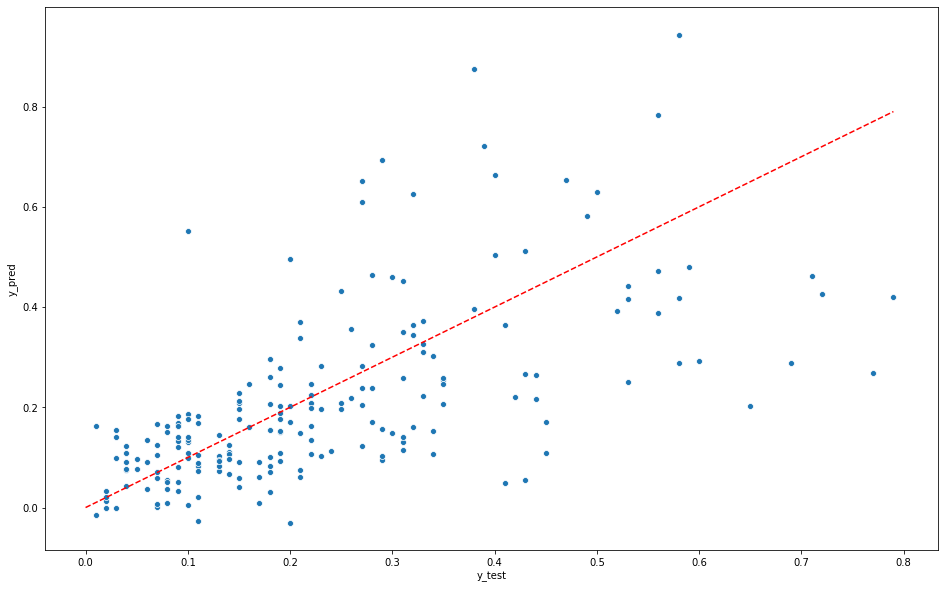

In [18]:
mlpres = NNregression(X_train, X_test, y_train, y_test,hidden_layer = 4, batch_size = 4,epoch=500,lr=0.008)


<h5 align="center">Table: Multi-Data scale results for simple NNSI (lr = 0.008, epoch = 500)</h5> 

Data setting   | Pearson's R |MSE 
---------------| ----| -----------
Scale-100/100/1e4/100|0.654237|0.018762
Scale-100/100/100/100|0.010924|0.035668
Scale-1/1/1e4/1|0.111105|356.680000
Scale-1/1/1e2/1|nan|nan
Scale-1/1/1/1|nan|nan
Scale-100/100/1e4/1|0.387243|274.734252
Log + Scale-100/100/1e4/100|0.644059|0.019181
Log + Scale-100/100/1e4/1|0.359238|331.834495
Log + Scale-1/1/1/1|nan|nan
Log + Scale-1/1/1e4/1|0.099469|356.679994


<h5 align="center">Table: Multi-Learning Rate results for simple NNSI (epoch = 500)</h5> 

Data setting   |Learn Rate | Pearson's R |MSE 
---------------|-----------| ----| -----------
Scale-100/100/1e4/100| 0.001|0.553725|0.023150
Scale-100/100/1e4/100| 0.005|0.661269|0.017935
Scale-100/100/1e4/100| 0.008|0.669105|0.017481
Scale-100/100/1e4/100| 0.01|0.667358|0.019225
Scale-100/100/1e4/100| 0.02|0.640021|0.021951
Scale-100/100/1e4/100| 0.05|0.620108|0.021694

<h5 align="center">Table: Multi-Epoch results for simple NNSI (lr = 0.008)</h5> 

Data setting   |Epoch | Pearson's R |MSE 
---------------|-----------| ----| -----------
Scale-100/100/1e4/100| 100|0.562694|0.022134
Scale-100/100/1e4/100| 200|0.613355|0.020226
Scale-100/100/1e4/100| 500|0.650066|0.017591
Scale-100/100/1e4/100| 1000|0.649216|0.020887
Scale-100/100/1e4/100| 1500|0.619646|0.026070
Scale-100/100/1e4/100| 2000|0.646771|0.024874
Scale-100/100/1e4/100| 2500|0.630125|0.022424

<h5 align="center">Table: Multi-Batch results for simple NNSI (lr = 0.008,epoch=500)</h5> 

Data setting   |Batch | Pearson's R |MSE 
---------------|-----------| ----| -----------
Scale-100/100/1e4/100|1|0.498238|0.031676
Scale-100/100/1e4/100|2|0.665648|0.017110
Scale-100/100/1e4/100|4|0.659888|0.017319
Scale-100/100/1e4/100|8|0.673677|0.016491
Scale-100/100/1e4/100|16|0.672827|0.016790
Scale-100/100/1e4/100|25|0.688240|0.016055
Scale-100/100/1e4/100|50|0.680170|0.014963
Scale-100/100/1e4/100|100|0.663591|0.015865

<h5 align="center">Table: Multi-Hidden layer results for simple NNSI (lr = 0.008,epoch=500,batch=4)</h5> 

Hidden layer number| Pearson's R |MSE 
-----------| ----| -----------
1|0.609333|0.019280
2|0.594150|0.022716
4|0.637684|0.020454
8|0.672389|0.017287
12|0.654698|0.017756
16|0.665197|0.017400

## Model Interpretation

### Interpretable models
#### Linear Regression

Easiest model to interpret, just by weight!

#### GLM

Also by weights


### Model-Agnostic Methods

#### Partial Dependence Plot (PDP)

Under development
:
have difficulty installing package

In [38]:
X_train = sm.add_constant(np.log(X_train))
X_test = sm.add_constant(np.log(X_test))
#glmresults.predict(X_train)

In [70]:
X_train

array([[ 1.        ,  0.32930375, -0.52763274,  0.62502112],
       [ 1.        ,  0.18232156, -0.63487827, -1.02865291],
       [ 1.        ,  0.16551444, -0.5798185 , -1.19631619],
       ...,
       [ 1.        , -0.34249031, -0.5798185 ,  0.06168401],
       [ 1.        ,  0.01980263, -0.56211892, -0.71502887],
       [ 1.        ,  0.12221763, -0.61618614,  0.33463189]])

In [25]:
mlpres.predict(X_train)

(800,)

In [20]:
# glm

im_model = InMemoryModel(glmresults.predict, examples=X_train 
                         )
interpreter = Interpretation(X_test,
                             feature_names=['const','Oi','Dj','dij'])

In [26]:
#mlp
im_model = InMemoryModel(mlpres.predict, examples=X_train 
                         )
interpreter = Interpretation(X_test,
                             feature_names=['Oi','Dj','dij'])

[4/4] features ████████████████████ Time elapsed: 0 seconds

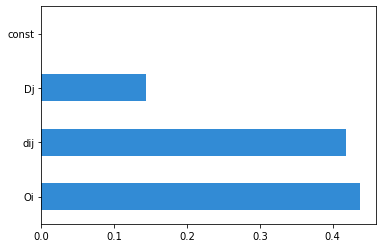

In [22]:
plots = interpreter.feature_importance.plot_feature_importance(im_model)

[19/19] grid cells ████████████████████ Time elapsed: 2 seconds

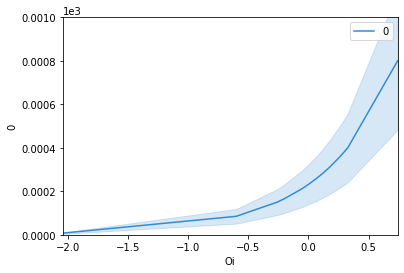

In [23]:
r = interpreter.partial_dependence.plot_partial_dependence(['Oi'], im_model, grid_resolution=20, 
                                                           grid_range=(0,1),
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

[15/15] grid cells ████████████████████ Time elapsed: 2 seconds

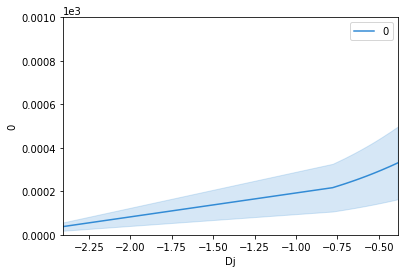

In [24]:
r = interpreter.partial_dependence.plot_partial_dependence(['Dj'], im_model, grid_resolution=20, 
                                                           grid_range=(0,1),
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

[20/20] grid cells ████████████████████ Time elapsed: 2 seconds

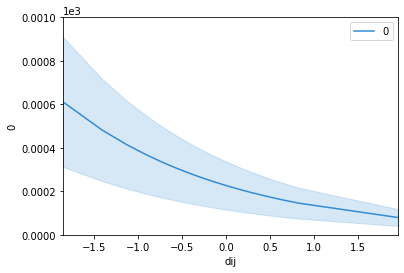

In [25]:
r = interpreter.partial_dependence.plot_partial_dependence(['dij'], im_model, grid_resolution=20, 
                                                           grid_range=(0,1),
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

#### Shapley Values and SHAP (SHapley Additive exPlanations)

In [39]:
X_train.shape

(800, 4)

In [40]:
explainer = shap.KernelExplainer(glmresults.predict,X_train)
shap_values = explainer.shap_values(X_test)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [55]:
i = 42
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[i], feature_names=['const','Oi','Di','dij'])

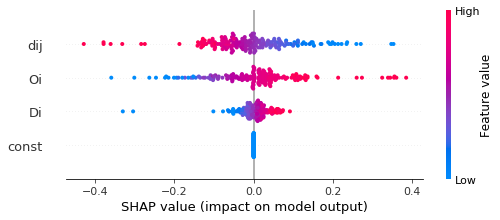

In [57]:
shap.summary_plot(shap_values, features=X_test,  feature_names=['const','Oi','Di','dij'])

### Example-Based Explanations

<h4> Counterfactual Explanations</h4>
 Under development

In [ ]:
!pip install alibi
#!pip install -U scikit-image --user

In [1]:
import alibi
alibi.explainers.__all__

ModuleNotFoundError: No module named 'alibi'

### Neural Network Interpretation??

Most existing literature are for image inputs. Few geospatial examples are used.

In [35]:
#legacy code
#prototyping code

# batch_size = 4

# #initialize network with fixed output dim of 1
# neural_network = NeuralNetwork(X_train.shape[1],1,lr=1e-3)

# for index in range(0,X_train.shape[0],batch_size):
    
    
#     #get batch X and Y
#     batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
#     batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])]
    
#     #train model with batch
#     neural_network.train(batch_X,batch_Y,500)
    
#     #print final state of weights
#     neural_network.print_w()

#     # Test the neural network with new test data. 
#     #get predicted y
#     y_pred = neural_network.test(X_test)
#     #compare predicted y and groundtruth 
# #     print('predicted data ----------->')
# #     print(y_pred)
# #     print('real data ---------------->')
# #     print(y_test)
#     #calculate MSE
#     mse = np.mean((y_test - y_pred)**2)
#     print('MSE on test data --------->')
#     print(mse)

In [ ]:

# integer

# probability matrix by divide sum see paper
